# Tecnicas de Clasificación de Texto
#### *Categoria:* *Machine Learning, NLP*
    Ing. Luengas R. Fabian

En este articulo discutiremos acerca de diferentes flujos de procesamiento de texto que nos permitan entrenar y obtener el mejor rendimiento de un modelo de clasificación binaria, aplicando tambien tecnicas Machine Learning. Las tecnicas que trataremos ya han sido estudiadas con anterioridad y garantizan un buen rendimiento según las particularidades de cada caso de clasificación, por tanto, tambien trataremos los diferentes tipos de modelos de clasificación.

Para esta revisión utilizaremos el dataset publico de www.kaggle.com donde se recopilan tweets que tratan o no de eventos catalogados como desastres climaticos.

### Librerias

In [146]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer


from sklearn import linear_model, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn import svm


from tensorflow import keras
from keras import models,layers,optimizers
from keras import regularizers 

import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los dos datasets, uno destinado para el entrenamiento y validación y el otro destinado para el testeo del modelo.

In [147]:
train_df = pd.read_csv('C:\\Users\\GAMER\\Documents\\Development\\Python\\notebook\\NLP\\getting-started\\train.csv')
test_df = pd.read_csv('C:\\Users\\GAMER\\Documents\\Development\\Python\\notebook\\NLP\\getting-started\\test.csv')

### EDA: Analisis Exploratorio de Datos

In [148]:
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [149]:
train_df[train_df['target'] == 1]['text'].values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [150]:
train_df[train_df['target'] == 0]['text'].values[2]

'Summer is lovely'

In [151]:
train_df.isna().sum(axis=0)/len(train_df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [152]:
train_df[train_df['location'].isna()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [153]:
train_df.target.value_counts()/(len(train_df.target))*100

0    57.034021
1    42.965979
Name: target, dtype: float64

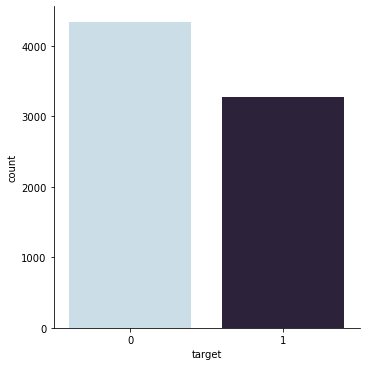

In [154]:
g = sns.catplot(x='target',kind='count',palette="ch:s=.25,rot=-.25",hue_order='target',data=train_df)

    TFIDF, LSA, LSTM / RNNs

In [165]:
train_x = train_df.text
train_y = train_df.target

Canalizaciones. Desarrollo de una lógica especifica de procesamiento de datos de tipo texto para incluir en un pipeline.

Se crea una clase de nuestro transformador de texto customizado, este transformador hereda los metodos de las clases BaseEstimator y TransformerMixin.

Los metodos relevantes que se heradan son:


In [178]:
def tokenize(X,y=None):
    tokenizer = nltk.RegexpTokenizer('\w+')
    X_ = []
    for i in X:
        X_.append(tokenizer.tokenize(i))
    return X_

def delete_stopwords(X,y=None):
    stopwords_ = stopwords.words('english')
    X_ = []
    for i in X:
        bag = [w.lower() for w in i if w.lower() not in stopwords_]
        X_.append(bag)
    return X_

def stopwords_percentage(text):
    stopwd = stopwords.words('english')
    content = [w for l in text for w in l if w.lower() in stopwd]
    total = [w for l in text for w in l if w.lower()]
    return len(content)/len(total)

def riqueza_lexica(text):
    text = [w for l in text for w in l]
    vocabulario = sorted(set(text))
    return len(vocabulario)/len(text)

def get_n_grams_collocations_from_words (words, freq_filter = 20, n_best= 50,
                                       n_gran_measure = nltk.collocations.BigramAssocMeasures()):
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(freq_filter)
    tweets_collocations = finder.nbest(n_gran_measure.pmi, n_best)
    return tweets_collocations

def do_bigrams(text):
    lista = []
    for row in text:
        lista.append(list(nltk.bigrams(row)))
    return lista

def build_vectors(train_x,feature_vector,doble=True):
    train_vectors = []
    for lista in train_x:
        sentences_vectors = []
        if doble:
            for word,freq in feature_vector:
                
                if word in lista:
                    sentences_vectors.append(1)
                else:
                    sentences_vectors.append(0)
        else:
            for word in feature_vector:
                if word in lista:
                    sentences_vectors.append(1)
                else:
                    sentences_vectors.append(0)
                    
        train_vectors.append(sentences_vectors)
    return train_vectors

def lemmatizer(train_x):
    lemmatizer = WordNetLemmatizer()
    lista = []
    for l in train_x:
        temp = [lemmatizer.lemmatize(w) for w in l]
        lista.append(temp)
    return lista
    

# train_x = tokenize(train_x)

In [167]:
porc_s = stopwords_percentage(train_x)
porc_s

0.3330616701137141

In [168]:
train_x = delete_stopwords(train_x)

In [169]:
riq = riqueza_lexica(train_x)
riq

0.24821313289679978

In [179]:
train_x = lemmatizer(train_x)

In [161]:
flatten = [w for l in train_x for w in l]

In [180]:
riq = riqueza_lexica(train_x)
riq

0.23403347781979156

### Transformación de los datos.

Los modelos de machine learning reciben como entrada vectores (Matrices de numeros) con los cuales desarrollan una serie de operaciones matematicas con el unico objetivo de ajustar un resultado, este resultado puede ser la clasificiación de una etiqueta en especifico o intentar acercarse a un valor determinado.

Para el caso del lenguaje natural, las palabras representan nuestras variables o caracteristicas que seran los insumos del modelo para operar, por tanto, deben transformarce de tal forma que estos modelos puedan hacer operaciones con ellas, a esto se le conoce como vectorización del texto. A continuación se ilustrará 3 formas validas para llevar a cabo este proceso.

#### Codificación One-Hot-Encoding.
Este tipo de transformación genera como resultado un vector disperso, ya que esta tecnica despliega un vector de cierto palabras donde se evalua la aparición 

In [181]:
dict_freq_words = nltk.FreqDist(flatten)
feature_vector = dict_freq_words.most_common(300)

In [182]:
train_vectors = build_vectors(train_x,feature_vector)
train_vectors = np.asarray(train_vectors).astype('float32')
train_y = np.asarray(train_y).reshape(7613,1).astype('float32')

In [183]:
scores = []
cv = KFold(n_splits=10,random_state=42,shuffle=True)
for train_index, test_index in cv.split(train_vectors):
    
    X_train, X_test, y_train, y_test = train_vectors[train_index], train_vectors[test_index], train_y[train_index], train_y[test_index]
    
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))

scores    

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

[0.7309711286089239,
 0.7637795275590551,
 0.7795275590551181,
 0.7437582128777924,
 0.7437582128777924,
 0.7792378449408672,
 0.7739816031537451,
 0.7608409986859396,
 0.7490144546649146,
 0.759526938239159]

In [109]:
cross_val_predict(clf, train_vectors, train_y, cv=10)

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected

array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)

In [184]:
logistic = LogisticRegression(random_state=0).fit(train_vectors, train_y)

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [185]:
logistic.score(train_vectors, train_y)

0.7772231708918954

In [186]:
y_pred = logistic.predict(train_vectors)

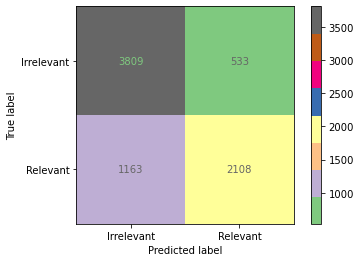

In [202]:
plot_confusion_matrix(logistic,train_vectors,train_y,display_labels=['Irrelevant','Relevant'],cmap='Accent')
plt.show()

In [188]:
print(classification_report(train_y,y_pred,target_names=['Irrelevant','Relevant']))

              precision    recall  f1-score   support

  Irrelevant       0.77      0.88      0.82      4342
    Relevant       0.80      0.64      0.71      3271

    accuracy                           0.78      7613
   macro avg       0.78      0.76      0.77      7613
weighted avg       0.78      0.78      0.77      7613



In [189]:
model = models.Sequential()
model.add(layers.Dense(30,activation='relu',input_shape= train_vectors.shape[1:],kernel_regularizer = regularizers.l2(0.003)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.004)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.0035)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.003)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics='accuracy')

In [190]:
len(train_vectors)*0.15

1141.95

In [191]:
x_val = train_vectors[:1142]
partial_x_train = train_vectors[1142:]

y_val = train_y[:1142]
partial_y_train = train_y[1142:]

In [192]:
history = model.fit(partial_x_train,partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val,y_val)
                   )

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 1.0977 - accuracy: 0.5607 - val_loss: 1.0359 - val_accuracy: 0.7005
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 1.0093 - accuracy: 0.6137 - val_loss: 0.9663 - val_accuracy: 0.6489
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.9403 - accuracy: 0.6608 - val_loss: 0.8981 - val_accuracy: 0.6813
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.8742 - accuracy: 0.6874 - val_loss: 0.8358 - val_accuracy: 0.7128
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.8097 - accuracy: 0.7160 - val_loss: 0.7858 - val_accuracy: 0.7049
Epoch 6/10
13/13 [==============================] - 0s 4ms/step - loss: 0.7507 - accuracy: 0.7376 - val_loss: 0.7256 - val_accuracy: 0.7513
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.7558 - val_loss: 0.7085 - val_accuracy: 0.7338
Epoch 8/10
13/13 [=

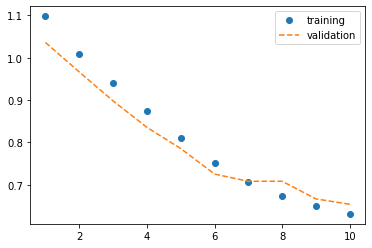

In [193]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epoch= range(1,len(loss_values)+1)

plt.plot(epoch,loss_values,'o',label='training')
plt.plot(epoch,val_loss_values,'--',label='validation')
plt.legend()
plt.show()

## ¿Mejorando el BOW?

In [194]:
collocation = get_n_grams_collocations_from_words(flatten,freq_filter = 30, n_best= 80)
feauture_vec_2 = []
train_x_2 = []
bigrams = do_bigrams(train_x)

In [195]:
for w,f in feature_vector:
    feauture_vec_2.append(w)
    
for bigram in collocation:
    feauture_vec_2.append(bigram)

In [196]:
for i in range(len(train_x)):
    temp = train_x[i] + bigrams[i]
    train_x_2.append(temp)

In [197]:
train_vectors_2 =  build_vectors(train_x_2,feauture_vec_2,doble=False)
train_vectors_2 = np.asarray(train_vectors_2).astype('float32')

In [198]:
x_val = train_vectors_2[:1142]
partial_x_train = train_vectors_2[1142:]

y_val = train_y[:1142]
partial_y_train = train_y[1142:]

In [199]:
model = models.Sequential()
model.add(layers.Dense(30,activation='relu',input_shape= train_vectors_2.shape[1:],kernel_regularizer = regularizers.l2(0.003)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.004)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.0035)))
model.add(layers.Dense(30,activation='relu',kernel_regularizer = regularizers.l2(0.003)))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics='accuracy')

In [200]:
history = model.fit(partial_x_train,partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val,y_val)
                   )

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 1.1019 - accuracy: 0.5505 - val_loss: 1.0293 - val_accuracy: 0.6900
Epoch 2/10
13/13 [==============================] - 0s 4ms/step - loss: 1.0089 - accuracy: 0.5925 - val_loss: 0.9542 - val_accuracy: 0.6926
Epoch 3/10
13/13 [==============================] - 0s 4ms/step - loss: 0.9349 - accuracy: 0.6704 - val_loss: 0.8931 - val_accuracy: 0.6734
Epoch 4/10
13/13 [==============================] - 0s 4ms/step - loss: 0.8612 - accuracy: 0.7039 - val_loss: 0.8124 - val_accuracy: 0.7320
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.7920 - accuracy: 0.7359 - val_loss: 0.7634 - val_accuracy: 0.7242
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.7381 - accuracy: 0.7518 - val_loss: 0.7371 - val_accuracy: 0.7329
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.6987 - accuracy: 0.7574 - val_loss: 0.7038 - val_accuracy: 0.7504
Epoch 8/10
13/13 [=

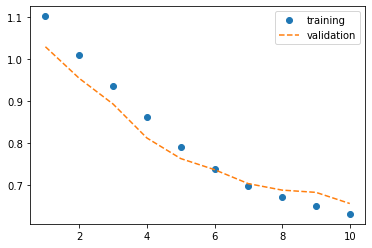

In [201]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epoch= range(1,len(loss_values)+1)

plt.plot(epoch,loss_values,'o',label='training')
plt.plot(epoch,val_loss_values,'--',label='validation')
plt.legend()
plt.show()